In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example dataset
np.random.seed(42)

df = pd.read_csv(r"..\data\processed\df.csv", 
                 index_col=0, 
                 parse_dates=True,
                     dtype={
                        "Open": float,
                        "High": float,
                        "Low": float,
                        "Close": float,
                        "Volume": float,  # ou int, se quiser
                    }).reset_index()
df

,Date,Close,High,Low,Open,Volume
0,2000-01-03,1.156394,1.156394,1.156394,1.156394,3.538944e+10
1,2000-01-04,1.092423,1.092423,1.092423,1.092423,2.886144e+10
2,2000-01-05,1.081400,1.081400,1.081400,1.081400,4.303360e+10
3,2000-01-06,1.077661,1.077661,1.077661,1.077661,3.405568e+10
4,2000-01-07,1.082582,1.082582,1.082582,1.082582,2.091264e+10
...,...,...,...,...,...,...
6468,2025-10-06,30.719999,31.230000,30.700001,31.200001,2.124540e+07
6469,2025-10-07,30.830000,30.860001,30.350000,30.719999,2.906880e+07
6470,2025-10-08,30.650000,31.080000,30.500000,31.080000,1.768740e+07
6471,2025-10-09,30.209999,30.840000,30.190001,30.660000,2.287970e+07


In [2]:
def validate_ohlc_consistency(df):
    """
    Checks logical consistency between OHLC values.
    """
    mask_high = (df['High'] < df[['Open', 'Close', 'Low']].max(axis=1))
    mask_low = (df['Low'] > df[['Open', 'Close', 'High']].min(axis=1))

    inconsistencies = pd.DataFrame({
        'invalid_high': mask_high,
        'invalid_low': mask_low
    })

    total = mask_high.sum() + mask_low.sum()

    print("=== OHLC CONSISTENCY VALIDATION ===")
    print(f"Invalid High entries: {mask_high.sum()}")
    print(f"Invalid Low entries: {mask_low.sum()}")
    print(f"Total inconsistencies: {total}")

    if total > 0:
        print("⚠️ WARNING: Inconsistent OHLC data detected!")

    return inconsistencies


In [3]:
df_inconsistencies = validate_ohlc_consistency(df)
df_inconsistencies

=== OHLC CONSISTENCY VALIDATION ===
Invalid High entries: 26
Invalid Low entries: 22
Total inconsistencies: 48
⚠️ WARNING: Inconsistent OHLC data detected!


,invalid_high,invalid_low
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
6468,False,False
6469,False,False
6470,False,False
6471,False,False


In [4]:
def fix_ohlc_inconsistencies(df):
    """
    Ensures High is the max and Low is the min for each row.
    """
    df['High'] = df[['Open', 'High', 'Low', 'Close']].max(axis=1)
    df['Low'] = df[['Open', 'High', 'Low', 'Close']].min(axis=1)
    print("✓ OHLC inconsistencies fixed.")
    return df

In [5]:
df_fixed = fix_ohlc_inconsistencies(df)
df_fixed

✓ OHLC inconsistencies fixed.


,Date,Close,High,Low,Open,Volume
0,2000-01-03,1.156394,1.156394,1.156394,1.156394,3.538944e+10
1,2000-01-04,1.092423,1.092423,1.092423,1.092423,2.886144e+10
2,2000-01-05,1.081400,1.081400,1.081400,1.081400,4.303360e+10
3,2000-01-06,1.077661,1.077661,1.077661,1.077661,3.405568e+10
4,2000-01-07,1.082582,1.082582,1.082582,1.082582,2.091264e+10
...,...,...,...,...,...,...
6468,2025-10-06,30.719999,31.230000,30.700001,31.200001,2.124540e+07
6469,2025-10-07,30.830000,30.860001,30.350000,30.719999,2.906880e+07
6470,2025-10-08,30.650000,31.080000,30.500000,31.080000,1.768740e+07
6471,2025-10-09,30.209999,30.840000,30.190001,30.660000,2.287970e+07


In [6]:
def detect_price_change_outliers(df, threshold_percent=10):
    """
    Detects outliers based on extreme daily % changes.
    """
    returns = df['Close'].pct_change() * 100
    outliers_mask = abs(returns) > threshold_percent

    print("\n=== PRICE CHANGE DETECTION ===")
    print(f"Threshold: {threshold_percent}%")
    print(f"Outliers detected: {outliers_mask.sum()} ({outliers_mask.sum()/len(df)*100:.2f}%)")

    if outliers_mask.sum() > 0:
        print(f"Max spike: {returns.max():.2f}% | Max drop: {returns.min():.2f}%")

    return outliers_mask


In [7]:
def detect_abnormal_gaps(df, threshold_percent=5):
    """
    Detects abnormal gaps between previous Close and current Open.
    """
    gap = ((df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100
    outliers_mask = abs(gap) > threshold_percent

    print("\n=== ABNORMAL GAP DETECTION ===")
    print(f"Threshold: {threshold_percent}%")
    print(f"Gaps detected: {outliers_mask.sum()}")

    return outliers_mask, gap


In [8]:
def detect_impossible_candles(df):
    """
    Detects candles with unrealistic characteristics:
    - Huge range (High-Low)
    - Zero volume
    """
    candle_range = ((df['High'] - df['Low']) / df['Close']) * 100
    Q1, Q3 = candle_range.quantile(0.25), candle_range.quantile(0.75)
    IQR = Q3 - Q1

    range_outliers = candle_range > (Q3 + 3 * IQR)
    zero_volume = df['Volume'] == 0

    print("\n=== IMPOSSIBLE CANDLES DETECTION ===")
    print(f"Abnormal range: {range_outliers.sum()}")
    print(f"Zero volume: {zero_volume.sum()}")

    return range_outliers | zero_volume


In [13]:
def detect_volume_outliers(df, threshold=3):
    """
    Detects abnormal volumes using Z-Score.
    Volume usually follows a log-normal distribution.
    """
    log_volume = np.log1p(df['Volume'])
    z_scores = np.abs((log_volume - log_volume.mean()) / log_volume.std())
    outliers_mask = z_scores > threshold

    print("\n=== ABNORMAL VOLUME DETECTION ===")
    print(f"Z-Score Threshold: {threshold}")
    print(f"Outliers detected: {outliers_mask.sum()} ({outliers_mask.sum()/len(df)*100:.2f}%)")

    return outliers_mask


In [14]:
def temporal_interpolation_treatment(df, outliers_mask):
    """
    Interpolates OHLC data to smooth out anomalies.
    """
    df = df.copy()
    for col in ['Open', 'High', 'Low', 'Close']:
        df.loc[outliers_mask, col] = np.nan
        df[col] = df[col].interpolate(method='linear', limit_direction='both')

    df.loc[outliers_mask, 'Volume'] = np.nan
    df['Volume'] = df['Volume'].fillna(df['Volume'].rolling(5, min_periods=1).mean())

    df['High'] = df[['Open', 'High', 'Low', 'Close']].max(axis=1)
    df['Low'] = df[['Open', 'High', 'Low', 'Close']].min(axis=1)

    print(f"\n✓ Temporal interpolation applied on {outliers_mask.sum()} rows.")
    return df


In [15]:
def visualize_treatment(df_original, df_treated, column='Close', window=50):
    """
    Plots before/after comparison of the treatment.
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    df_orig_plot = df_original.tail(window)
    df_treat_plot = df_treated.tail(window)

    axes[0].plot(df_orig_plot.index, df_orig_plot[column], color='red', label='Original')
    axes[0].set_title(f"{column} - BEFORE TREATMENT", fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(df_treat_plot.index, df_treat_plot[column], color='green', label='Treated')
    axes[1].set_title(f"{column} - AFTER TREATMENT", fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(df_orig_plot.index, df_orig_plot[column], color='red', alpha=0.5, label='Original')
    axes[2].plot(df_treat_plot.index, df_treat_plot[column], color='green', linestyle='--', label='Treated')
    axes[2].set_title("COMPARISON", fontsize=14)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


=== OHLC CONSISTENCY VALIDATION ===
Invalid High entries: 0
Invalid Low entries: 0
Total inconsistencies: 0
✓ OHLC inconsistencies fixed.

=== PRICE CHANGE DETECTION ===
Threshold: 10%
Outliers detected: 40 (0.62%)
Max spike: 22.22% | Max drop: -29.70%

=== ABNORMAL VOLUME DETECTION ===
Z-Score Threshold: 3
Outliers detected: 146 (2.26%)

=== ABNORMAL GAP DETECTION ===
Threshold: 5%
Gaps detected: 116

=== IMPOSSIBLE CANDLES DETECTION ===
Abnormal range: 80
Zero volume: 146

Total outliers: 320 (4.94%)

✓ Temporal interpolation applied on 320 rows.


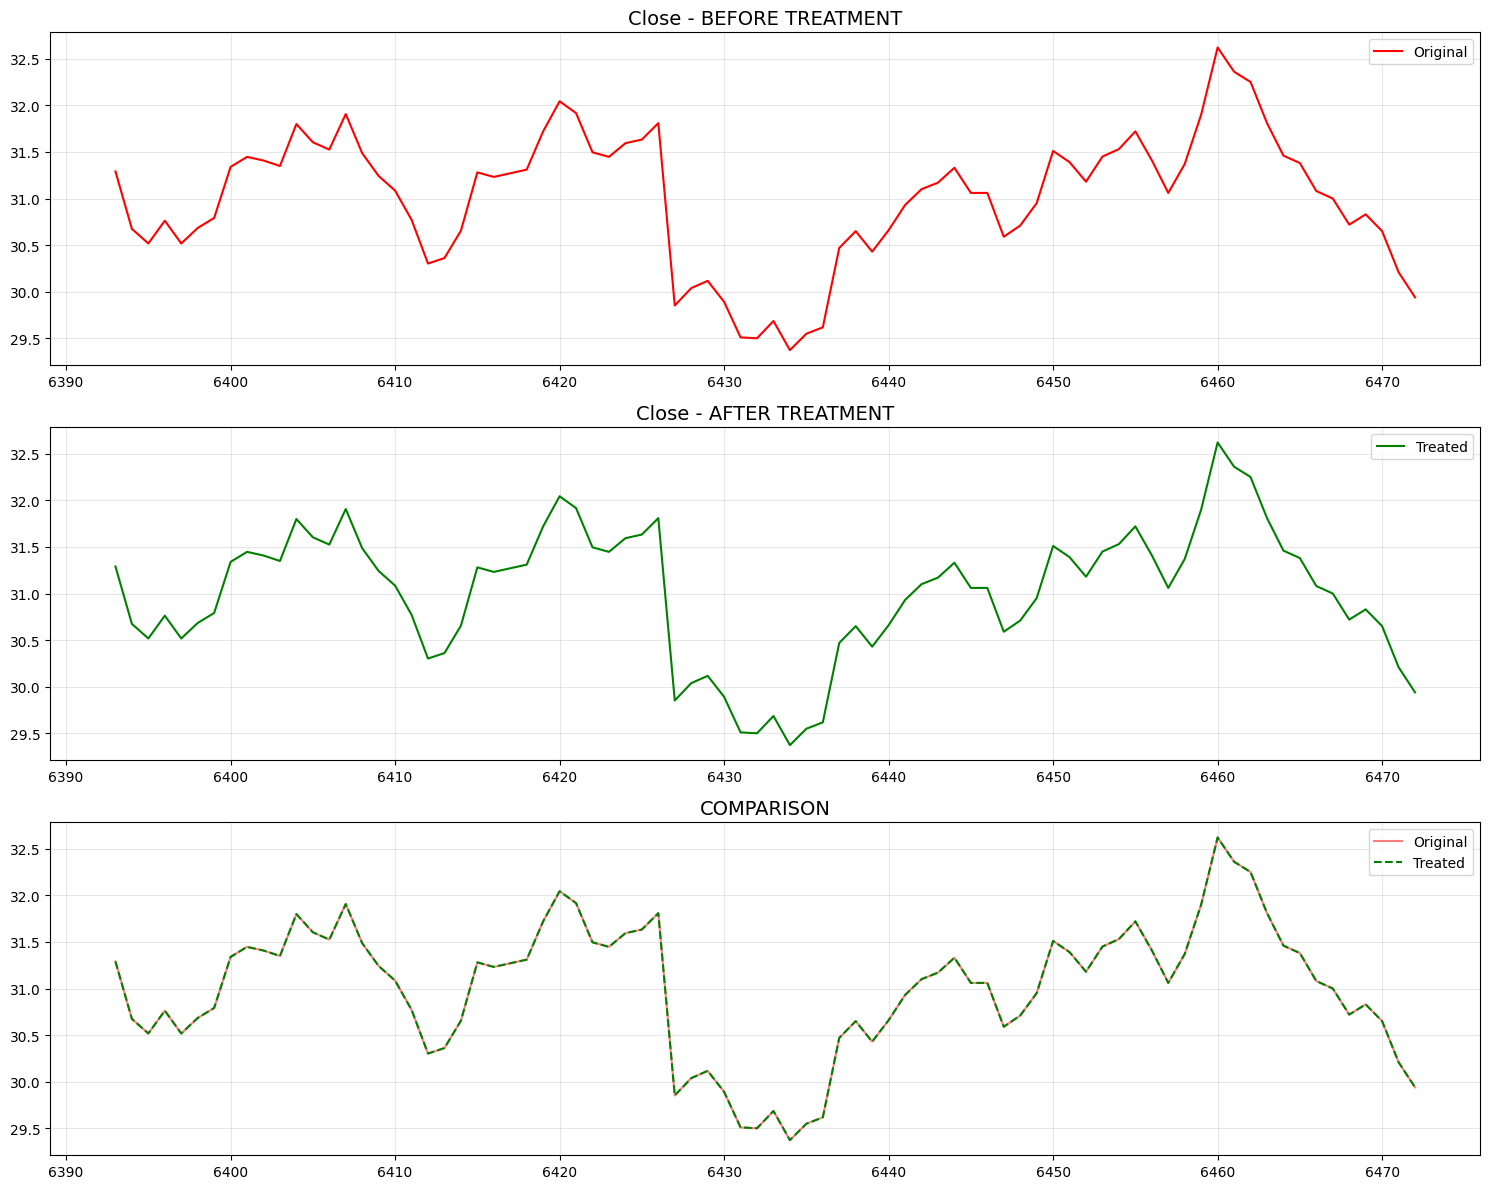

In [16]:
# Validate and fix inconsistencies
incons = validate_ohlc_consistency(df)
df = fix_ohlc_inconsistencies(df)

# Detect outliers
out_price = detect_price_change_outliers(df, 10)
out_vol = detect_volume_outliers(df, 3)
out_gap, _ = detect_abnormal_gaps(df, 5)
out_candle = detect_impossible_candles(df)

# Combine all masks
outliers = out_price | out_vol | out_gap | out_candle
print(f"\nTotal outliers: {outliers.sum()} ({outliers.sum()/len(df)*100:.2f}%)")

# Treat them
df_treated = temporal_interpolation_treatment(df, outliers)

# Visualize
visualize_treatment(df, df_treated, 'Close', 80)
